In [3]:
%pip install gplearn


In [4]:
import pandas as pd
import numpy as np
import math
import random
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, Perceptron, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer,TransformedTargetRegressor
from gplearn.genetic import SymbolicRegressor
from sklearn.metrics import PredictionErrorDisplay
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
import warnings

First few rows of the dataset:
   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0

Summary statistics:
                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192    4.559477   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   68.600000  437.700000    6.500000   
50%      4.000000    4.000000   91.6

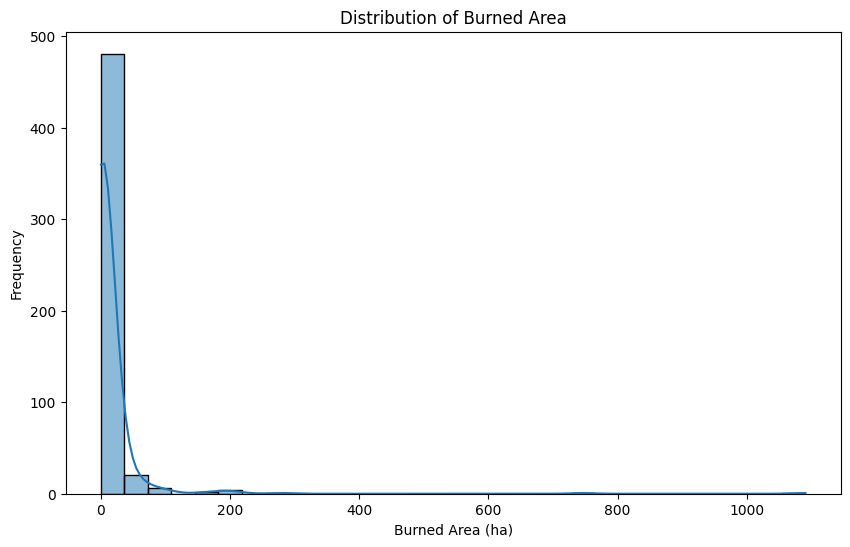

<Figure size 1200x1000 with 0 Axes>

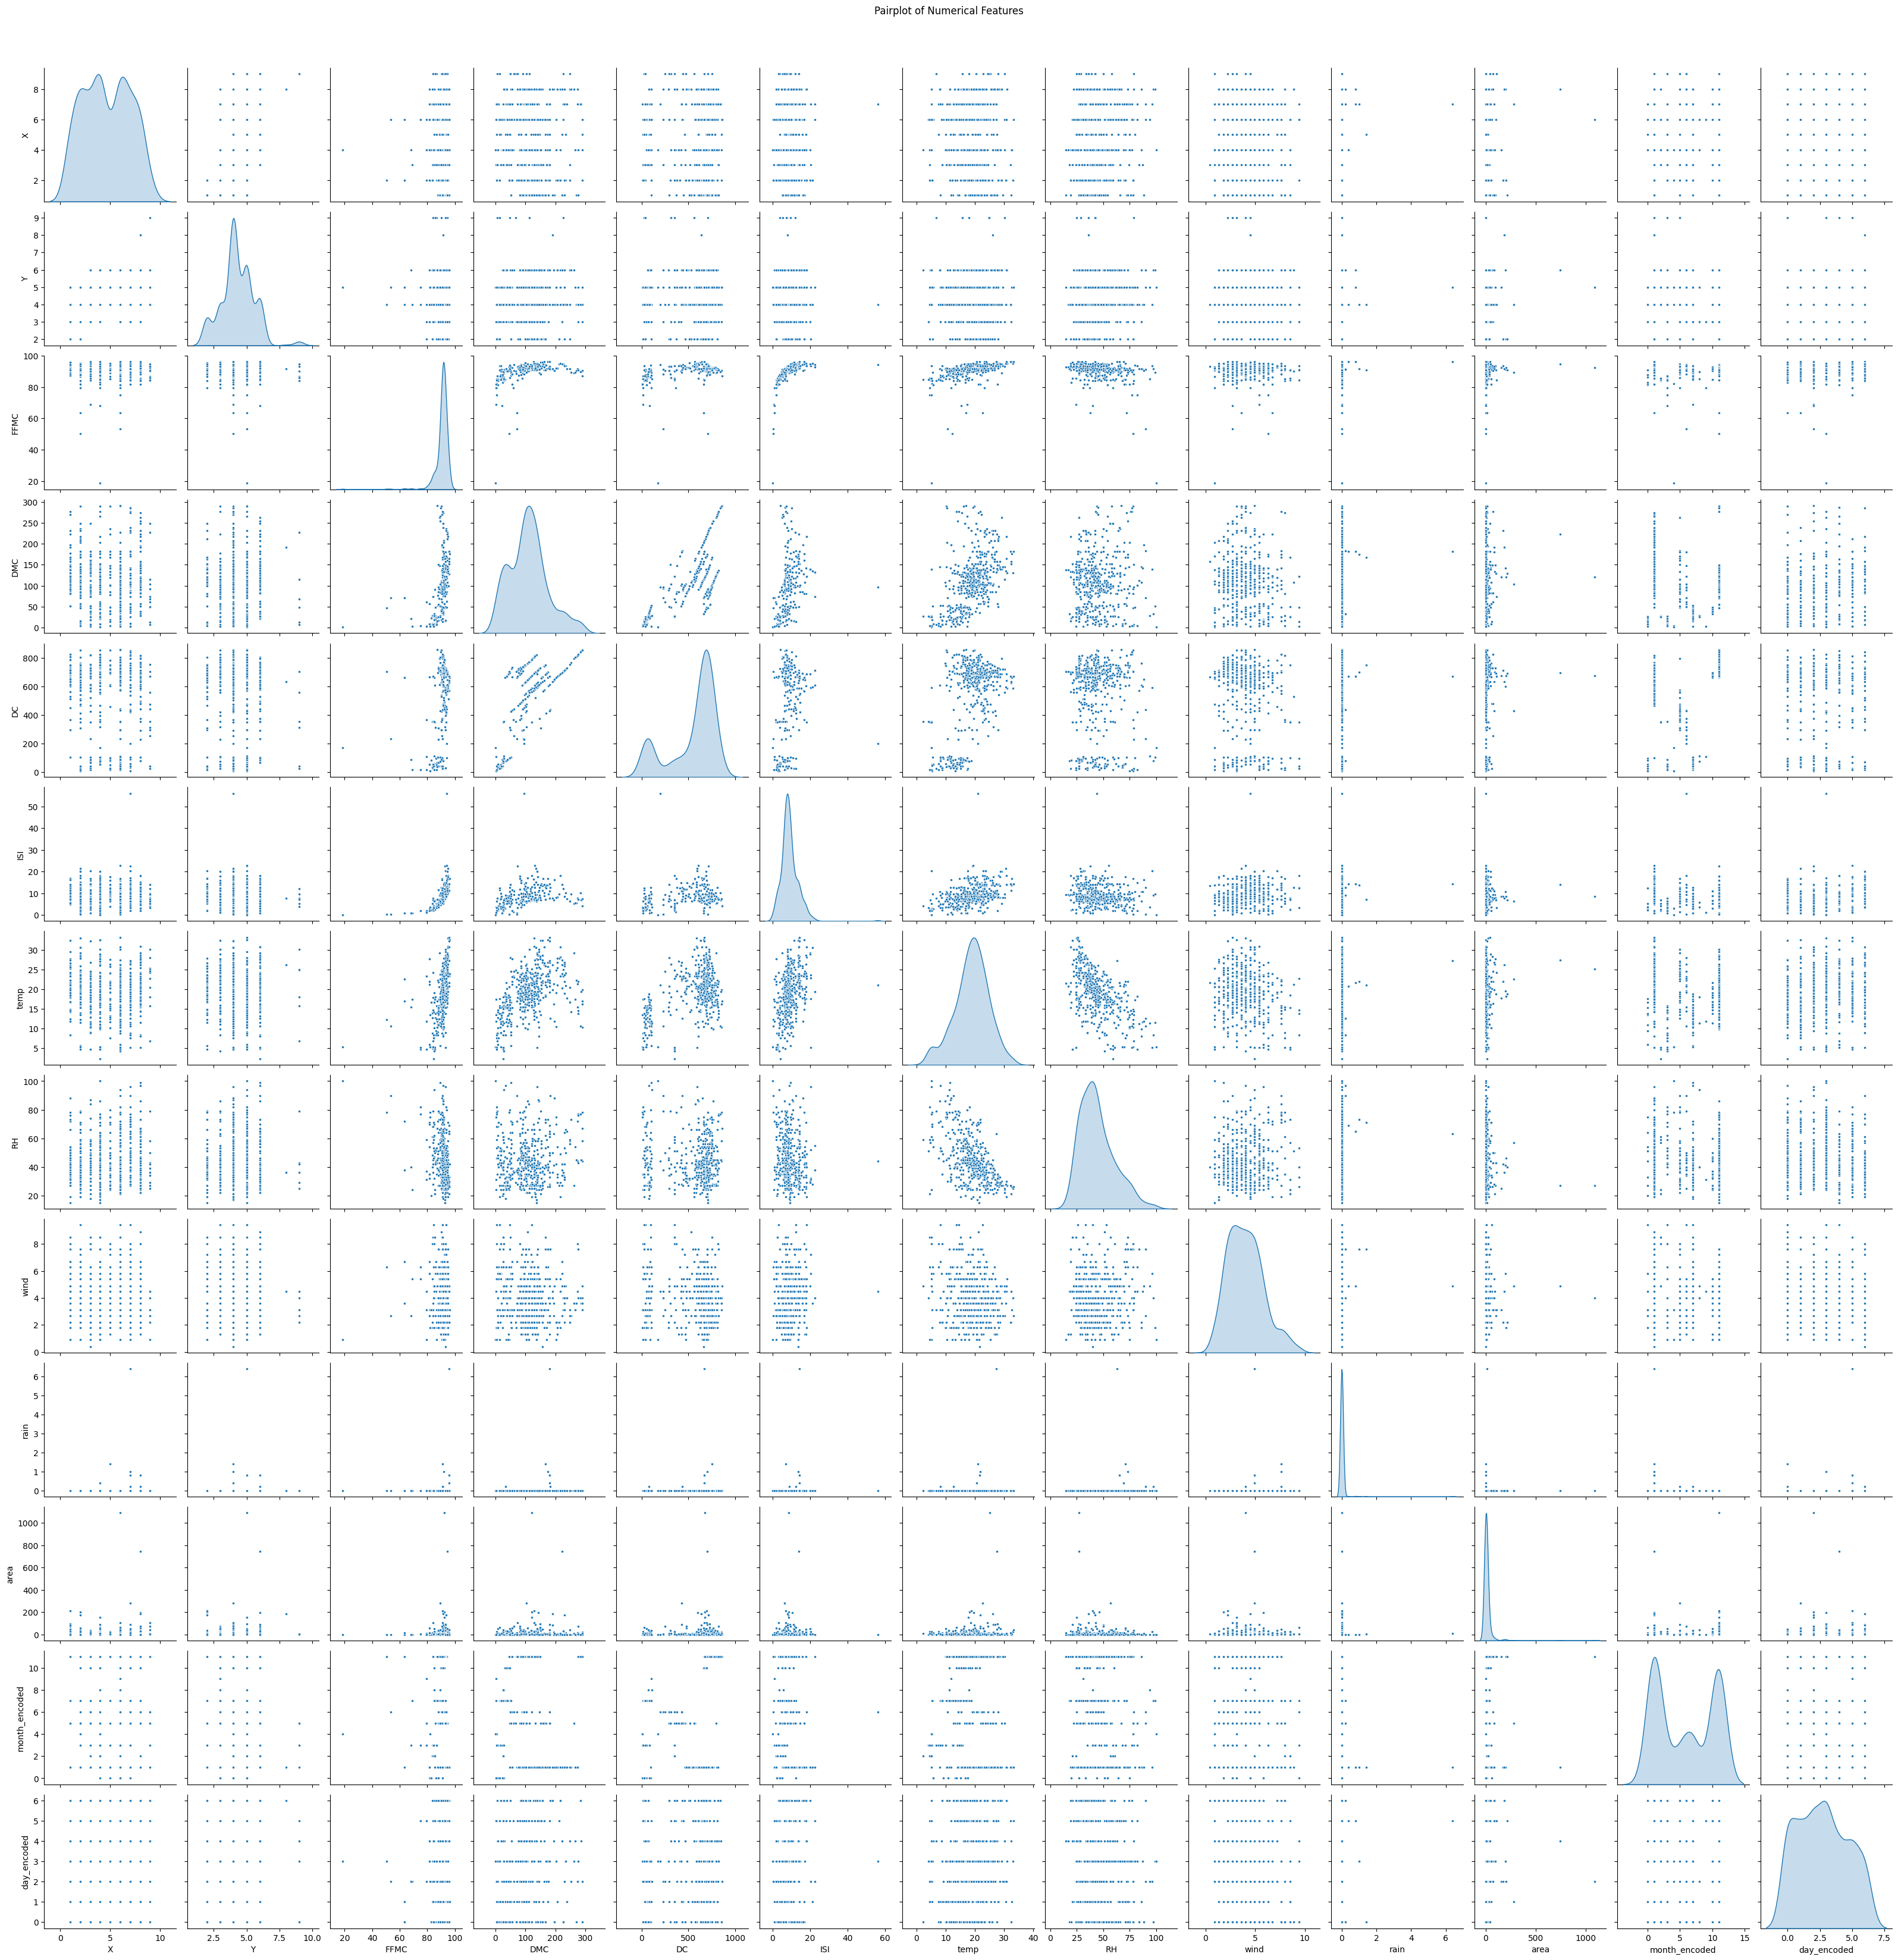

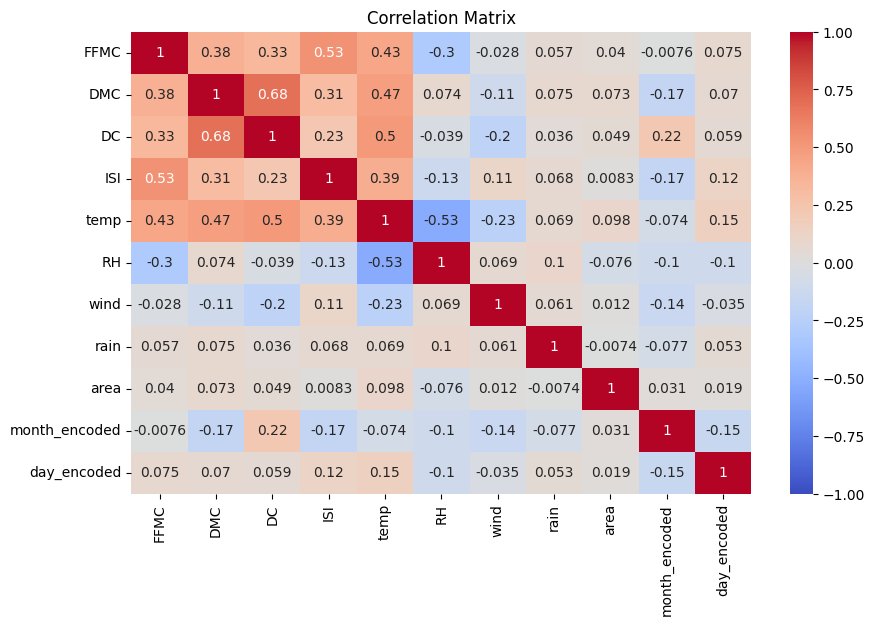

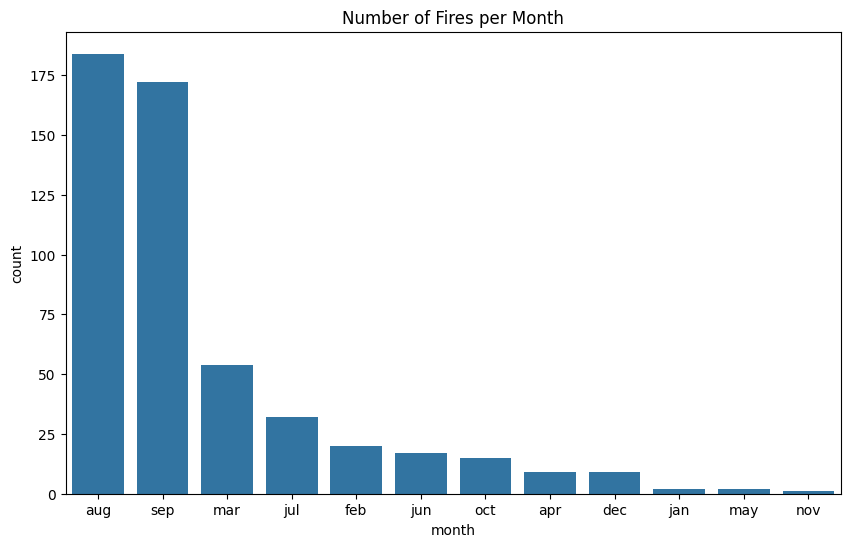

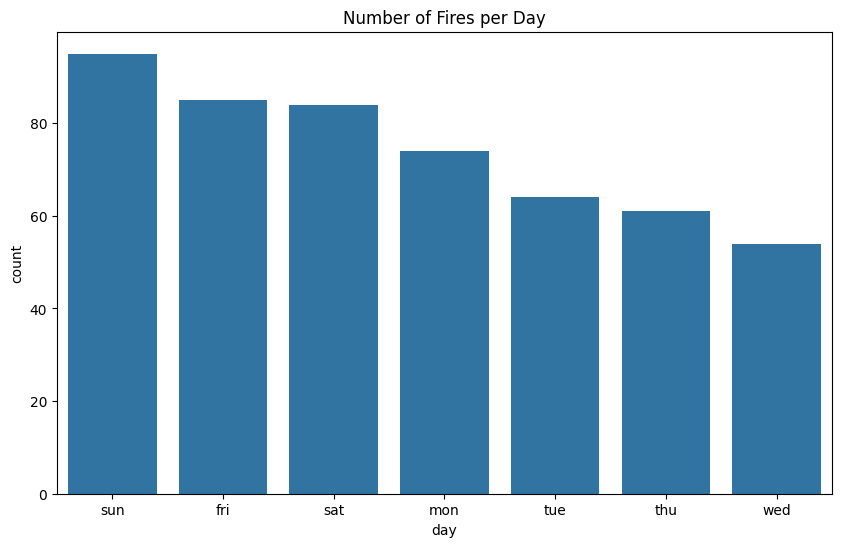

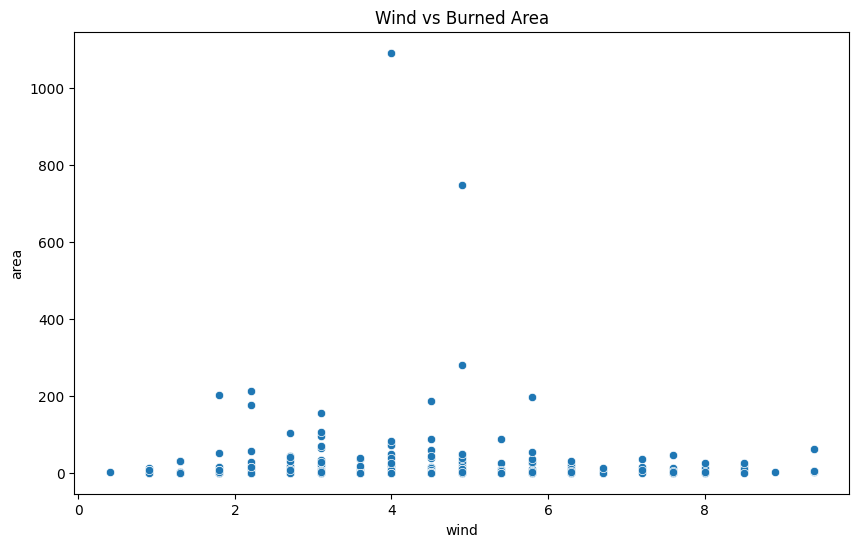

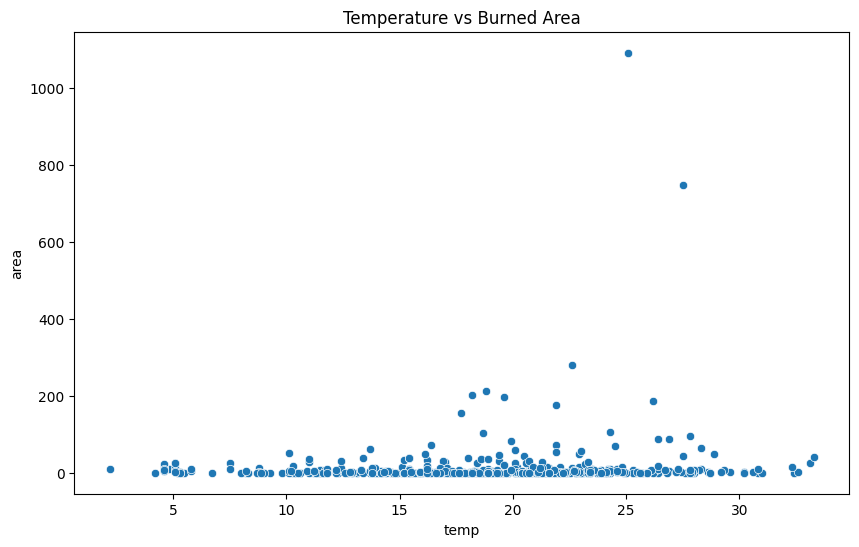

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv"
df = pd.read_csv(url)

print("First few rows of the dataset:")
print(df.head())

print("\nSummary statistics:")
print(df.describe())

print("\nMissing values in the dataset:")
print(df.isnull().sum())

print("\nData types of the columns:")
print(df.dtypes)

df['month'] = df['month'].astype('category')
df['day'] = df['day'].astype('category')

label_encoder = LabelEncoder()
df['month_encoded'] = label_encoder.fit_transform(df['month'])
df['day_encoded'] = label_encoder.fit_transform(df['day'])

plt.figure(figsize=(10, 6))
sns.histplot(df['area'], bins=30, kde=True)
plt.title('Distribution of Burned Area')
plt.xlabel('Burned Area (ha)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 10))
sns.pairplot(df.select_dtypes(include=['float64', 'int64']), diag_kind='kde', markers='.')
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

plt.figure(figsize=(10, 6))
corr_matrix = df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area', 'month_encoded', 'day_encoded']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Month-wise fire occurrences
plt.figure(figsize=(10, 6))
sns.countplot(x='month', data=df, order=df['month'].value_counts().index)
plt.title('Number of Fires per Month')
plt.show()

# Day-wise fire occurrences
plt.figure(figsize=(10, 6))
sns.countplot(x='day', data=df, order=df['day'].value_counts().index)
plt.title('Number of Fires per Day')
plt.show()

# Exploring the effect of wind on area burned
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind', y='area', data=df)
plt.title('Wind vs Burned Area')
plt.show()

# Exploring the effect of temperature on area burned
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='area', data=df)
plt.title('Temperature vs Burned Area')
plt.show()


# New Section

In [6]:
# df.head()

# rain and area to be dropped.
# df.drop('rain', inplace= True, axis= 1)
# df.drop('area', inplace= True, axis= 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   X              517 non-null    int64   
 1   Y              517 non-null    int64   
 2   month          517 non-null    category
 3   day            517 non-null    category
 4   FFMC           517 non-null    float64 
 5   DMC            517 non-null    float64 
 6   DC             517 non-null    float64 
 7   ISI            517 non-null    float64 
 8   temp           517 non-null    float64 
 9   RH             517 non-null    int64   
 10  wind           517 non-null    float64 
 11  rain           517 non-null    float64 
 12  area           517 non-null    float64 
 13  month_encoded  517 non-null    int64   
 14  day_encoded    517 non-null    int64   
dtypes: category(2), float64(8), int64(5)
memory usage: 54.4 KB


In [7]:
label_encoder = LabelEncoder()
df["month"]=label_encoder.fit_transform(pd.Categorical(df["month"],categories=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],ordered=True))
df["day"]=label_encoder.fit_transform(pd.Categorical(df["day"],categories=['sun','mon','tue','wed','thu','fri','sat'],ordered=True))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X              517 non-null    int64  
 1   Y              517 non-null    int64  
 2   month          517 non-null    int64  
 3   day            517 non-null    int64  
 4   FFMC           517 non-null    float64
 5   DMC            517 non-null    float64
 6   DC             517 non-null    float64
 7   ISI            517 non-null    float64
 8   temp           517 non-null    float64
 9   RH             517 non-null    int64  
 10  wind           517 non-null    float64
 11  rain           517 non-null    float64
 12  area           517 non-null    float64
 13  month_encoded  517 non-null    int64  
 14  day_encoded    517 non-null    int64  
dtypes: float64(8), int64(7)
memory usage: 60.7 KB


In [8]:
# null_values = autompg.isnull().sum()  # autompg.isnull returns an array of booleans
# print(null_values)  # no null values, no imputation needed
import numpy as np

def find_outliers_z_score(df: pd.DataFrame, column: str) -> pd.DataFrame:
    mean = df[column].mean()
    std_deviation = df[column].std()
    z_scores = (df[column] - mean) / std_deviation
    outliers = df[np.abs(z_scores) > 3]
    if len(outliers) > 0:
        return pd.DataFrame(outliers)
    else:
        return "No outliers"


print("-" * 50)
print(
    "Outliers according to Z score"
)  # outliers are points with a z score greater than 3
for colName in df.columns:
    print("Column name:", colName)
    df_outliers = find_outliers_z_score(df, colName)
    print(df_outliers)
    # print()
df_outliers=find_outliers_z_score(df, colName)
print("-" * 50)

--------------------------------------------------
Outliers according to Z score
Column name: X
No outliers
Column name: Y
     X  Y  month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain    area  \
75   9  9      3    4  84.2    6.8   26.6   7.7   6.7  79   3.1   0.0    0.00   
76   9  9      3    0  86.6   13.2   43.0   5.3  15.7  43   3.1   0.0    0.00   
138  9  9      5    5  85.8   48.3  313.4   3.9  18.0  42   2.7   0.0    0.36   
151  9  9      5    3  90.1   68.6  355.2   7.2  24.8  29   2.2   0.0    1.36   
402  9  9      1    0  94.8  227.0  706.7  12.0  25.0  36   4.0   0.0    0.00   
420  8  8      1    6  91.7  191.4  635.9   7.8  26.2  36   4.5   0.0  185.76   
480  9  9      5    4  93.2  114.4  560.0   9.5  30.2  25   4.5   0.0    2.75   

     month_encoded  day_encoded  
75               3            4  
76               3            0  
138              5            5  
151              5            3  
402              1            0  
420              1      

In [9]:
import numpy as np
import pandas as pd

# Function to find outliers using Z-score
def find_outliers_z_score(df: pd.DataFrame, column: str) -> pd.DataFrame:
    mean = df[column].mean()
    std_deviation = df[column].std()
    z_scores = (df[column] - mean) / std_deviation
    outliers = df[np.abs(z_scores) > 3]
    return outliers

# DataFrame to store all outliers
all_outliers = pd.DataFrame()

# Iterating over each column in the DataFrame
print("-" * 50)
print("Outliers according to Z score")

for colName in df.select_dtypes(include=[np.number]).columns:
    print("Column name:", colName)
    df_outliers = find_outliers_z_score(df, colName)
    if not df_outliers.empty:
        all_outliers = pd.concat([all_outliers, df_outliers])

# Dropping duplicate outliers if any
all_outliers = all_outliers.drop_duplicates()

# Display all the outliers
print("All Outliers found:")
print(all_outliers)

# Remove outliers from the original DataFrame using their index
df_cleaned = df.drop(all_outliers.index)

print("-" * 50)
print("DataFrame after removing outliers:")
print(df_cleaned)


--------------------------------------------------
Outliers according to Z score
Column name: X
Column name: Y
Column name: month
Column name: day
Column name: FFMC
Column name: DMC
Column name: DC
Column name: ISI
Column name: temp
Column name: RH
Column name: wind
Column name: rain
Column name: area
Column name: month_encoded
Column name: day_encoded
All Outliers found:
     X  Y  month  day  FFMC    DMC     DC   ISI  temp   RH  wind  rain  \
75   9  9      3    4  84.2    6.8   26.6   7.7   6.7   79   3.1   0.0   
76   9  9      3    0  86.6   13.2   43.0   5.3  15.7   43   3.1   0.0   
138  9  9      5    5  85.8   48.3  313.4   3.9  18.0   42   2.7   0.0   
151  9  9      5    3  90.1   68.6  355.2   7.2  24.8   29   2.2   0.0   
402  9  9      1    0  94.8  227.0  706.7  12.0  25.0   36   4.0   0.0   
420  8  8      1    6  91.7  191.4  635.9   7.8  26.2   36   4.5   0.0   
480  9  9      5    4  93.2  114.4  560.0   9.5  30.2   25   4.5   0.0   
12   6  5      1    0  63.5   70.

In [10]:
df.to_csv('/content/output.csv',index=False)

In [11]:
df_cleaned

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,month_encoded,day_encoded
0,7,5,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,7,0
1,7,4,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,10,5
2,7,4,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,10,2
5,8,6,1,3,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.00,1,3
6,8,6,1,1,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.00,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,1,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,1,3
513,2,4,1,3,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,1,3
514,7,4,1,3,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,1,3
515,1,4,1,2,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,1,2


In [17]:
y = pd.DataFrame(df_cleaned[["area"]])
X = pd.DataFrame(df_cleaned.drop(columns=["area"]))


X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=True, shuffle=True
)

# Define a function to calculate adjusted R-squared
def adj_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

# Turn off warnings
warnings.filterwarnings("ignore")  # category = UserWarning

In [18]:
def shuffle_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # add a random seed to ensure randomness
    random.seed(42)
    # shuffle the indices of the pd.DataFrame
    df = df.reindex(np.random.permutation(df.index))
    # df.index = current values of indices of a pd.DataFrame. returns an array
    # np.random.permutation(df.index) = shuffles the supplied array
    # df.reindex(np.random.permutation(df.index)) = applied the shuffled indices to the pd.DataFrame object
    return df


# define adjusted r2 function
def adjusted_r2_score(XTest: pd.DataFrame, r2: float) -> float:
    n = XTest.shape[0]  # number of rows
    p = XTest.shape[1]  # number of columns
    adj_r2 = 1 - (1 - r2) * (n - 1) / (
        n - p - 1
    )  # adjusted r squared formula, applies penalty to the use of extra parameters
    return adj_r2

In [19]:

# First a simple linear model
linearRegressionModel = LinearRegression()
linearRegressionModel.fit(X, y)
# make predictions on the test data
y_predictions = linearRegressionModel.predict(X)

# r2 score
r2 = r2_score(y, y_predictions)
# calculate adjusted r2
adj_r2 = adjusted_r2_score(X, r2)
# print metrics
print("Linear Regression")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()

# create a lasso regression model
lassoRegressionModel = Lasso()
# fit the model to the training data
lassoRegressionModel.fit(X, y)
# make predictions on the test data
y_predictions = lassoRegressionModel.predict(X)
# evaluate the model using R^2
r2 = r2_score(y, y_predictions)
adj_r2 = adjusted_r2_score(X, r2)
print("Lasso Regression")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()

# create a ridge regression model
ridgeRegressionModel = Ridge()
# fit the model to the training data
ridgeRegressionModel.fit(X, y)
# make predictions on the test data
y_predictions = ridgeRegressionModel.predict(X)
# evaluate the model using R^2
r2 = r2_score(y, y_predictions)
adj_r2 = adjusted_r2_score(X, r2)
print("Ridge Regression")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()

#create a symbolic Regression
symbolicRegressionModel = SymbolicRegressor(population_size=1000, generations=20, tournament_size=5, n_jobs=-1)
symbolicRegressionModel.fit(X, y)
y_predictions = symbolicRegressionModel.predict(X)
# evaluate the model using R^2
r2 = r2_score(y, y_predictions)
adj_r2 = adjusted_r2_score(X, r2)
print("Symbolic Regression")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()


#create a transformed Regression
transformedRegressionModel = TransformedTargetRegressor(regressor=RidgeCV(), func=np.log1p, inverse_func=np.expm1)
# fit the model to the training data
transformedRegressionModel.fit(X, y)
# make predictions on the test data
y_predictions = transformedRegressionModel.predict(X)
# evaluate the model using R^2
r2 = r2_score(y, y_predictions)
adj_r2 = adjusted_r2_score(X, r2)
print("Transformed ridge Regression")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()

#create a Pereptron
perceptronModel = MLPRegressor(random_state=1, max_iter=1000)
# fit the model to the training data
perceptronModel.fit(X,y)
# make predictions on the test data
y_predictions = perceptronModel.predict(X)
# evaluate the model using R^2
r2 = r2_score(y, y_predictions)
adj_r2 = adjusted_r2_score(X, r2)
print("Perceptron")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()



Linear Regression
R2: 0.016925082577969985
Adjusted R2: -0.012233919209971633

Lasso Regression
R2: 0.0135972870735791
Adjusted R2: -0.015660420513221585

Ridge Regression
R2: 0.016797528624462488
Adjusted R2: -0.012365256543455994

Symbolic Regression
R2: -0.12351897295241776
Adjusted R2: -0.1568436882518538

Transformed ridge Regression
R2: -0.07578440052260715
Adjusted R2: -0.10769325986014211

Perceptron
R2: 0.023475086996851524
Adjusted R2: -0.005489634999004567



In [20]:

# create a linear regression model
linearRegressionModel = LinearRegression()
# fit the model to the training data
linearRegressionModel.fit(X_train, y_train)
# make predictions on the test data
y_predictions = linearRegressionModel.predict(X_test)
# calculate r2
r2 = r2_score(y_test, y_predictions)
# calculate adjusted r2
adj_r2 = adjusted_r2_score(X_train, r2)
# print metrics
print("Linear Regression")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()



# create a lasso regression model
lassoRegressionModel = Lasso()
# fit the model to the training data
lassoRegressionModel.fit(X_train, y_train)
# make predictions on the test data
y_predictions = lassoRegressionModel.predict(X_test)
# calculate r2
r2 = r2_score(y_test, y_predictions)
# calculate adjusted r2
adj_r2 = adjusted_r2_score(X_train, r2)
print("Lasso Regression")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()


# create a ridge regression model
ridgeRegressionModel = Ridge()
# fit the model to the training data
ridgeRegressionModel.fit(X_train, y_train)
# make predictions on the test data
y_predictions = ridgeRegressionModel.predict(X_test)
# calculate r2
r2 = r2_score(y_test, y_predictions)
# calculate adjusted r2
adj_r2 = adjusted_r2_score(X_train, r2)

print("Ridge Regression")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()


#create a symbolic Regression
symbolicRegressionModel = SymbolicRegressor()
symbolicRegressionModel.fit(X_train, y_train)
y_predictions = symbolicRegressionModel.predict(X_test)
# evaluate the model using R^2
r2 = r2_score(y_test, y_predictions)
adj_r2 = adjusted_r2_score(X_train, r2)
print("Symbolic Regression")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()


#create a transformed Regression
transformedRegressionModel = TransformedTargetRegressor(regressor=RidgeCV(), func=np.log1p, inverse_func=np.expm1)
# fit the model to the training data
transformedRegressionModel.fit(X_train, y_train)
# make predictions on the test data
y_predictions = transformedRegressionModel.predict(X_test)
# evaluate the model using R^2
r2 = r2_score(y_test, y_predictions)
adj_r2 = adjusted_r2_score(X_train, r2)
print("Transformed ridge Regression")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()

# #create a Pereptron
# perceptronModel = MLPRegressor(random_state=1, max_iter=1000)
# # fit the model to the training data
# perceptronModel.fit(X_train,y_train)
# # make predictions on the test data
# y_predictions = perceptronModel.predict(X_test)
# # evaluate the model using R^2
# r2 = r2_score(y_test, y_predictions)
# adj_r2 = adjusted_r2_score(X_train, r2)
# print("Perceptron")
# print("R2:", r2)
# print("Adjusted R2:", adj_r2)
# print()


Linear Regression
R2: -0.04159882894698552
Adjusted R2: -0.08058915944232714

Lasso Regression
R2: -0.018790259799863485
Adjusted R2: -0.05692679358916308

Ridge Regression
R2: -0.03543483908299194
Adjusted R2: -0.07419443198984199

Symbolic Regression
R2: -0.11252236843323327
Adjusted R2: -0.1541675907810014

Transformed ridge Regression
R2: -0.07649937136069873
Adjusted R2: -0.11679613927259647

